In [56]:
import sys, os
sys.path.insert(0, "/home/storage/hans/jax_reco_new")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

import jax.numpy as jnp
from jax.scipy import optimize
import jax
jax.config.update("jax_enable_x64", True)
import optimistix as optx

from jax.scipy.special import gammaincc, erf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lib.smallest_network_eqx import get_network_eval_fn
from lib.trafos import transform_network_outputs, transform_network_inputs
from lib.plotting import adjust_plot_1d

from dom_track_eval import get_eval_network_doms_and_track

from jax.scipy.stats.norm import pdf as norm_pdf
from jax.scipy.stats.norm import logpdf as norm_logpdf

from lib.gamma_sf_approx import gamma_sf_fast

In [57]:
eval_network = get_network_eval_fn(bpath='/home/storage/hans/photondata/large_table_training/all_time_bins/w_penalty_b5/cache/test_penalties_tree_start_epoch_160', dtype=jnp.float64)

In [58]:
dist = 5
z = -500
rho = 0.0
zenith = np.pi/2
azimuth = 0.0

x = jnp.array([dist, rho, z, zenith, azimuth])
x_prime = transform_network_inputs(x)
y = eval_network(x_prime)
logits, gamma_as, gamma_bs = transform_network_outputs(y)
mix_probs = jax.nn.softmax(logits)
log_mix_probs = jnp.log(mix_probs)
# index 1 is main component
g_a = gamma_as
g_b = gamma_bs
sigma = 3

print(gamma_as, gamma_bs, mix_probs)

[1.00151594 1.07198408 5.66846037] [3.55536324e-03 9.51488047e-02 4.06963271e+00] [0.0579739  0.20219347 0.73983263]


In [59]:
from lib.c_mpe_gamma import c_multi_gamma_mpe_logprob_midpoint2 
c_multi_gamma_mpe_logprob_midpoint2_v1dx = jax.jit(jax.vmap(c_multi_gamma_mpe_logprob_midpoint2, 
                                                            (0, None, None, None, None, None),
                                                            0
                                                        )
                                                  )

from lib.c_mpe_gamma import c_multi_gamma_mpe_prob_midpoint2 
c_multi_gamma_mpe_prob_midpoint2_v1dx = jax.jit(jax.vmap(c_multi_gamma_mpe_prob_midpoint2, 
                                                            (0, None, None, None, None, None),
                                                            0
                                                        )
                                                  )

from lib.c_spe_gamma import c_multi_gamma_spe_prob
c_multi_gamma_spe_prob_v1dx = jax.jit(jax.vmap(c_multi_gamma_spe_prob, 
                                                            (0, None, None, None, None),
                                                            0
                                                        )
                                                  )

In [60]:
def c_multi_gamma_mpe_prob_midpoint2_custom(x, mix_probs, a, b, n, sigma=3.0):
    """
    Q < 30
    """
    nmax = 10
    nint1 = 10
    nint2 = 15
    nint3 = 35
    
    eps000 = 1.e-12
    eps00 = 1.e-6
    eps = 1.e-3
    #eps = 1.e-6
    
    xvals000 = jnp.logspace(jnp.log(eps000), jnp.log(eps00-eps000), 10)
    xvals00 = jnp.logspace(jnp.log(eps00), jnp.log(eps-eps00), 10)
    
    x0 = eps
    x_m0 = 0.01
    xvals0 = jnp.linspace(x0, x_m0, 10)

    x_m1 = 0.05
    xvals1 = jnp.linspace(x_m0, x_m1, 10)

    x_m2 = 0.25
    xvals2 = jnp.linspace(x_m1, x_m2, 10)

    x_m25 = 0.75
    xvals25 = jnp.linspace(x_m2, x_m25, 10)

    x_m3 = 2.5
    xvals3 = jnp.linspace(x_m25, x_m3, 10)

    x_m4 = 8.0
    xvals4 = jnp.linspace(x_m3, x_m4, 20)

    #x_m5 = 6000.0
    #xvals5 = jnp.linspace(x_m4, x_m5, 20)

    #xmin = jnp.max(jnp.array([1.5 * eps, x - 4 * sigma]))
    #xmax = jnp.max(jnp.array([xmin+1.5*eps, x + 4 * sigma]))
    #xvals_x = jnp.linspace(xmin, xmax, 30)
    #xvals = jnp.sort(jnp.concatenate([xvals0, xvals1, xvals2, xvals25, xvals3, xvals4, xvals5, xvals_x]))
    xmin = jnp.max(jnp.array([1.5 * eps, x - 10 * sigma]))
    xmax = jnp.max(jnp.array([xmin+1.5*eps, x + 10 * sigma]))
    xvals_x = jnp.linspace(xmin, xmax, 101)
    xvals = jnp.sort(jnp.concatenate([xvals000, xvals00, xvals0, xvals1, xvals2, xvals25, xvals3, xvals4, xvals_x]))

    dx = xvals[1:]-xvals[:-1]

    xvals = 0.5*(xvals[:-1]+xvals[1:])
    n_pdf = norm_pdf(xvals, loc=x, scale=sigma)

    a_e = jnp.expand_dims(a, axis=-1)
    b_e = jnp.expand_dims(b, axis=-1)
    mix_probs_e = jnp.expand_dims(mix_probs, axis=-1)

    xvals_e = jnp.expand_dims(xvals, axis=0)
    sfs = jnp.sum(mix_probs_e * jnp.clip(gamma_sf_fast(xvals_e, a_e, b_e), min=1.e-300, max=None), axis=0)
    pdfs = jnp.sum(mix_probs_e * jnp.clip(gamma_pdf(xvals_e, a_e, scale=1./b_e), min=0, max=None), axis=0)

    return jnp.sum(n_pdf * n * pdfs * jnp.power(sfs, n-1.0) * dx)

c_multi_gamma_mpe_prob_midpoint2_custom_v1dx = jax.jit(jax.vmap(c_multi_gamma_mpe_prob_midpoint2_custom, 
                                                            (0, None, None, None, None, None),
                                                            0
                                                        )
                                                  )

2024-12-17 23:01:52.704172: W external/xla/xla/tsl/framework/bfc_allocator.cc:497] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.27GiB (rounded to 1360801024)requested by op 
2024-12-17 23:01:52.704256: W external/xla/xla/tsl/framework/bfc_allocator.cc:508] *______*******************************************************************************************xx
E1217 23:01:52.704271 2983560 pjrt_stream_executor_client.cc:3085] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1360801000 bytes.


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1360801000 bytes.

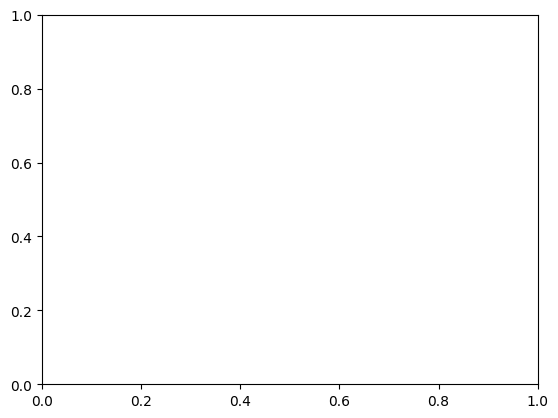

In [61]:
n_p = 40

fig, ax = plt.subplots()
xvals = np.linspace(-30, 50, 100000)
yvals = c_multi_gamma_mpe_logprob_midpoint2_v1dx(xvals, log_mix_probs, g_a, g_b, n_p, jnp.array(3.0))
yvals = jnp.exp(yvals)
plt.plot(xvals, yvals, color='tab:blue')

yvals2 = c_multi_gamma_mpe_prob_midpoint2_v1dx(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))
plt.plot(xvals, yvals2, color='tab:orange', linestyle='dashed')

yvals3 = c_multi_gamma_spe_prob_v1dx(xvals, mix_probs, g_a, g_b, jnp.array(3.0))
plt.plot(xvals, yvals3, color='tab:red', linestyle='dotted')

yvals4 = norm_pdf(xvals, 0.0, 3.0)
plt.plot(xvals, yvals4, "k--")

yvals5 = c_multi_gamma_mpe_prob_midpoint2_custom_v1dx(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))
plt.plot(xvals, yvals5, color='magenta', linestyle='dashed')

y_max = jnp.max(yvals4)
plot_args = {'xlim':[-30, 50],
                     'ylim':[0.0, 1.2*y_max],
                     #'ylim':[0.0, 0.5],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.title(f"distance from track {dist:.1f}m ")
plt.tight_layout()
plt.legend(fontsize=8)
plt.show()

In [ ]:
fig, ax = plt.subplots()
xvals = np.linspace(-100, 100, 100000)
yvals = c_multi_gamma_mpe_logprob_midpoint2_v1dx(xvals, log_mix_probs, g_a, g_b, n_p, jnp.array(3.0))
plt.plot(xvals, yvals, color='tab:blue')

yvals2 = c_multi_gamma_mpe_prob_midpoint2_v1dx(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))
yvals2 = jnp.log(yvals2)
plt.plot(xvals, yvals2, color='tab:orange', linestyle='dashed')

yvals3 = c_multi_gamma_spe_prob_v1dx(xvals, mix_probs, g_a, g_b, jnp.array(3.0))
yvals3 = jnp.log(yvals3)
plt.plot(xvals, yvals3, color='tab:red', linestyle='dotted')

yvals4 = norm_logpdf(xvals, 0.0, 3.0)
plt.plot(xvals, yvals4, "k--")

yvals5 = c_multi_gamma_mpe_prob_midpoint2_custom_v1dx(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))
yvals5 = jnp.log(yvals5)
plt.plot(xvals, yvals5, color='magenta', linestyle='dashed')

y_max = jnp.max(yvals)
y_min = jnp.min(yvals)
plot_args = {'xlim':[-20, 100],
                     'ylim':[0.8*y_max, y_min],
                     #'ylim':[0.0, 0.5],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.title(f"distance from track {dist:.1f}m ")
plt.tight_layout()
plt.legend(fontsize=8)
plt.show()

In [ ]:
print(yvals5)

In [ ]:
n_p = 10000

fig, ax = plt.subplots()
xvals = np.linspace(-10, 10, 100000)
yvals = c_multi_gamma_mpe_logprob_midpoint2_v1dx(xvals, log_mix_probs, g_a, g_b, n_p, jnp.array(3.0))
plt.plot(xvals, yvals, color='tab:blue')

yvals2 = c_multi_gamma_mpe_prob_midpoint2_v1dx(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))
yvals2 = jnp.log(yvals2)
plt.plot(xvals, yvals2, color='tab:orange', linestyle='dashed')

yvals3 = c_multi_gamma_spe_prob_v1dx(xvals, mix_probs, g_a, g_b, jnp.array(3.0))
yvals3 = jnp.log(yvals3)
plt.plot(xvals, yvals3, color='tab:red', linestyle='dotted')

yvals4 = norm_logpdf(xvals, 0.0, 3.0)
plt.plot(xvals, yvals4, "k--")

y_max = jnp.max(yvals)
y_min = jnp.min(yvals)
plot_args = {'xlim':[-10, 10],
                     'ylim':[0.8*y_max, y_min],
                     #'ylim':[0.0, 0.5],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.title(f"distance from track {dist:.1f}m ")
plt.tight_layout()
plt.legend(fontsize=8)
plt.show()

In [ ]:
yvals = c_multi_gamma_mpe_logprob_midpoint2_v1dx(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))
print(yvals)

In [ ]:
yvals = c_multi_gamma_mpe_prob_midpoint2_v1dx(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))
print(jnp.log(yvals))

In [ ]:
g_a

In [ ]:
dist = 20
z = -500
rho = 0.0
zenith = np.pi/2
azimuth = 0.0

x = jnp.array([dist, rho, z, zenith, azimuth])
x_prime = transform_network_inputs(x)
y = eval_network(x_prime)
logits, gamma_as, gamma_bs = transform_network_outputs(y)
mix_probs = jax.nn.softmax(logits)
log_mix_probs = jnp.log(mix_probs)
# index 1 is main component
g_a = gamma_as
g_b = gamma_bs
sigma = 3

print(gamma_as, gamma_bs, mix_probs)

In [ ]:
xvals = np.linspace(0, 20000, 100000)

from lib.gamma_sf_approx import regularized_lower_incomplete_gamma_approx

def gamma_cdf_approx(x, a, b):
    return regularized_lower_incomplete_gamma_approx(x*b, a)

gamma_pdf_approx = jax.grad(gamma_cdf_approx)
gamma_pdf_approx_v = jax.vmap(gamma_pdf_approx, (0, None, None), 0)

In [ ]:
pdf1 = gamma_pdf_approx_v(xvals, g_a[0], g_b[0])
pdf2 = gamma_pdf_approx_v(xvals, g_a[1], g_b[1])
pdf3 = gamma_pdf_approx_v(xvals, g_a[2], g_b[3])
pdf = jnp.concatenate([jnp.expand_dims(pdf1, axis=0),
                          jnp.expand_dims(pdf2, axis=0),
                          jnp.expand_dims(pdf3, axis=0)
                      ], axis=0)

mix_pdf = jnp.sum(jnp.expand_dims(mix_probs, axis=1) * pdf, axis=0)

In [ ]:
yvals3 = c_multi_gamma_spe_prob_v1dx(xvals, mix_probs, g_a, g_b, jnp.array(3.0))
plt.plot(xvals, yvals3, color='tab:red', linestyle='dotted')

plt.plot(xvals, mix_pdf)

In [ ]:
from lib.gamma_sf_approx import regularized_lower_incomplete_gamma_approx

def gamma_cdf_approx(x, a, b):
    return regularized_lower_incomplete_gamma_approx(x*b, a)

gamma_pdf_approx = jax.grad(gamma_cdf_approx)
gamma_pdf_approx_v = jax.vmap(gamma_pdf_approx, (0, None, None), 0)
gamma_pdf_approx_vv = jax.vmap(gamma_pdf_approx_v, (None, 0, 0), 0)

def multi_gamma_pdf_approx(x, a, b, mix_probs):
    pdf = jax.vmap(gamma_pdf_approx, (None, 0, 0), 0)(x, a, b)
    return jnp.sum(mix_probs * pdf)

In [ ]:
def c_multi_gamma_spe_prob_approx(x, mix_probs, a, b, sigma=3.0):
    nmax = 20
    nint1 = 20
    nint2 = 20
    nint3 = 50 

    xmax = jnp.max(jnp.array([jnp.array(nmax * sigma), x + nmax * sigma]))
    diff = xmax-x
    xmin = jnp.max(jnp.array([jnp.array(0.0), x - diff]))
    x_m1 = xmin + 0.02*sigma
    x_m2 = x_m1 + 0.5*sigma

    # two combined the two integration regions
    xvals = jnp.concatenate([jnp.linspace(xmin, x_m1, nint1),
                             jnp.linspace(x_m1, x_m2, nint2),
                             jnp.linspace(x_m2, xmax, nint3)])

    dx = xvals[1:]-xvals[:-1]

    xvals = 0.5*(xvals[:-1]+xvals[1:])
    n_pdf = norm_pdf(xvals, loc=x, scale=sigma)

    _e = jnp.expand_dims(a, axis=-1)
    #b_e = jnp.expand_dims(b, axis=-1)
    mix_probs_e = jnp.expand_dims(mix_probs, axis=-1)

    #xvals_e = jnp.expand_dims(xvals, axis=0)
    #pdfs = jnp.sum(mix_probs_e * gamma_pdf_approx_vv(xvals_e, a_e, scale=1./b_e), axis=0)
    pdfs = jnp.sum(mix_probs_e * gamma_pdf_approx_vv(xvals, a, b), axis=0)

    return jnp.sum(n_pdf * pdfs * dx)

c_multi_gamma_spe_prob_approx_v1dx = jax.vmap(c_multi_gamma_spe_prob_approx, (0, None, None, None, None), 0)

In [ ]:
multi_gamma_pdf_approx(5.0, g_a, g_b, mix_probs)

In [ ]:
jnp.sum(mix_pdf) * (xvals[1]-xvals[0])

In [ ]:
print(c_multi_gamma_spe_prob_approx(5.0, mix_probs, g_a, g_b, 3.0))
print(c_multi_gamma_spe_prob(5.0, mix_probs, g_a, g_b, 3.0))

In [ ]:
dist = 100
z = 500
rho = 0.0
zenith = np.pi/2
azimuth = 0.0

x = jnp.array([dist, rho, z, zenith, azimuth])
x_prime = transform_network_inputs(x)
y = eval_network(x_prime)
logits, gamma_as, gamma_bs = transform_network_outputs(y)
mix_probs = jax.nn.softmax(logits)
log_mix_probs = jnp.log(mix_probs)
# index 1 is main component
g_a = gamma_as
g_b = gamma_bs
sigma = 3

print(gamma_as, gamma_bs, mix_probs)

In [ ]:
xvals = np.linspace(-20, 2000, 100000)
yvals1 = c_multi_gamma_spe_prob_v1dx(xvals, mix_probs, g_a, g_b, 3.0) 
yvals2 = c_multi_gamma_spe_prob_approx_v1dx(xvals, mix_probs, g_a, g_b, 3.0) 

In [ ]:
plt.plot(xvals, yvals1)
plt.plot(xvals, yvals2, linestyle='dashed', label='approx')

In [ ]:
plt.plot(xvals, yvals1)
plt.plot(xvals, yvals2, linestyle='dashed', label='approx')
plt.yscale('log')

In [ ]:
print(g_a)

In [ ]:

print(g_b)

In [ ]:
def c_multi_gamma_mpe_prob_approx(x, mix_probs, a, b, n, sigma=3.0):
    nmax = 20
    nint1 = 20
    nint2 = 20
    nint3 = 50 

    xmax = jnp.max(jnp.array([jnp.array(nmax * sigma), x + nmax * sigma]))
    diff = xmax-x
    xmin = jnp.max(jnp.array([jnp.array(0.0), x - diff]))
    x_m1 = xmin + 0.02*sigma
    x_m2 = x_m1 + 0.5*sigma

    # two combined the two integration regions
    xvals = jnp.concatenate([jnp.linspace(xmin, x_m1, nint1),
                             jnp.linspace(x_m1, x_m2, nint2),
                             jnp.linspace(x_m2, xmax, nint3)])

    dx = xvals[1:]-xvals[:-1]

    xvals = 0.5*(xvals[:-1]+xvals[1:])
    n_pdf = norm_pdf(xvals, loc=x, scale=sigma)

    mix_probs_e = jnp.expand_dims(mix_probs, axis=-1)
    pdfs = jnp.sum(mix_probs_e * gamma_pdf_approx_vv(xvals, a, b), axis=0)

    a_e = jnp.expand_dims(a, axis=-1)
    b_e = jnp.expand_dims(b, axis=-1)
    xvals_e = jnp.expand_dims(xvals, axis=0)
    sfs = jnp.sum(mix_probs_e * gamma_sf_fast(xvals_e, a_e, b_e), axis=0)

    return jnp.sum(n_pdf * n * pdfs * jnp.power(sfs, n-1.0) * dx)

c_multi_gamma_mpe_prob_approx_v1dx = jax.vmap(c_multi_gamma_mpe_prob_approx, (0, None, None, None, None, None), 0)

In [ ]:
from lib.cgamma import c_multi_gamma_mpe_prob_v1d_x

In [ ]:
dist = 75
z = 200
rho = 0.0
zenith = np.pi/2
azimuth = 0.0

x = jnp.array([dist, rho, z, zenith, azimuth])
x_prime = transform_network_inputs(x)
y = eval_network(x_prime)
logits, gamma_as, gamma_bs = transform_network_outputs(y)
mix_probs = jax.nn.softmax(logits)
log_mix_probs = jnp.log(mix_probs)
# index 1 is main component
g_a = gamma_as
g_b = gamma_bs
sigma = 3

print(gamma_as, gamma_bs, mix_probs)

In [ ]:
n_p = 100
xvals = np.linspace(-20, 100, 100000)
yvals1 = c_multi_gamma_mpe_prob_midpoint2_v1dx(xvals, mix_probs, g_a, g_b, n_p, 3.0) 
yvals2 = c_multi_gamma_mpe_prob_approx_v1dx(xvals, mix_probs, g_a, g_b, n_p, 3.0)
yvals3 = c_multi_gamma_mpe_prob_v1d_x(xvals, mix_probs, g_a, g_b, n_p, 3.0, 0.1) 
yvals4 = norm_pdf(xvals, 0.0, 3.0)

In [ ]:
plt.plot(xvals, yvals1)
plt.plot(xvals, yvals2, linestyle='dashed', label='approx')
plt.plot(xvals, yvals3, linestyle='dashed', label='approx', color='black')
#plt.plot(xvals, yvals4, label='approx', color='black')

In [ ]:
plt.plot(xvals, yvals1)
plt.plot(xvals, yvals2, linestyle='dashed', label='approx')
plt.plot(xvals, yvals3, linestyle='dashed', label='approx', color='black')
plt.plot(xvals, yvals4, label='approx', color='black')

plt.yscale('log')
plt.ylim(ymin=1.e-10)

In [ ]:
print(np.sum(yvals1 * (xvals[1]-xvals[0])))
print(np.sum(yvals2 * (xvals[1]-xvals[0])))

In [ ]:
jnp.exp(-700)

In [ ]:
jnp.log(1.e-320)

In [ ]:
jnp.exp(-736)

In [ ]:
jax.numpy.finfo(jnp.float64).smallest_normal